In [27]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torchmetrics.classification import BinaryAccuracy
import matplotlib.pyplot as plt
import argparse
from training.train_selective_ssm import train_ssm_block, calculate_params
from training.load_datasets import get_imdb, create_majority_dataset, get_listops
from models.selective_ssm import SentimentModel, MultiClassModel
import csv
from einops import rearrange, repeat, einsum
import time
import re


In [28]:
# # Experiment parameters for the paper:
# devID = 0
# experiment = "length_independence"
# dataset = "majority"
# if dataset == "imdb":
#     T_values = range(100,2001,100)      # Sequence lengths
#     s_A_values = [0.0]                  # Stability margins
#     N = 4                               # Number of states per channel
#     d = 16                              # Number of channels
#     m = 25000                           # Number of samples
#     m_test = 25000                      # Number of test samples
#     ep = 30                             # Number of epochs
#     bs = 256                            # Batch size
#     lr = 1e-2                           # Learning rate
#     wd = 1e-5                           # Weight decay
#     delta = True                        # Use input dependent delta
#     seed = 0                            # Random seed
# elif dataset == "majority":
#     T_values = range(25,401,25)         # Sequence lengths
#     s_A_values = [0.0]                  # Stability margins
#     N = 4                               # Number of states per channel
#     d = 16                              # Number of channels
#     m = 1000                            # Number of samples
#     m_test = 1000                       # Number of test samples
#     ep = 40                             # Number of epochs
#     bs = 64                             # Batch size
#     lr = 1e-2                           # Learning rate
#     wd = 1e-5                           # Weight decay
#     delta = True                        # Use input dependent delta
#     seed = 0                            # Random seed
# else:
#     raise ValueError("Invalid dataset")

In [29]:
# Choose parameters to load the model
save_results = True
devID = 1
experiment = "length_independence"
dataset = "imdb"

if dataset == "imdb":
    T_values = range(100,1501,100)      # Sequence lengths
    s_A_values = [0.0]                  # Stability margins
    N = 4                               # Number of states per channel
    d = 16                              # Number of channels
    m = 25000                           # Number of samples
    m_test = 25000                      # Number of test samples
    ep = 30                             # Number of epochs
    bs = 256                            # Batch size
    lr = 1e-2                           # Learning rate
    wd = 1e-5                           # Weight decay
    delta = True                        # Use input dependent delta
    run = 3                             # run of model
elif dataset == "majority":
    T_values = range(25,401,25)         # Sequence lengths
    s_A_values = [0.0]                  # Stability margins
    N = 4                               # Number of states per channel
    d = 4                              # Number of channels
    m = 1000                            # Number of samples
    m_test = 1000                       # Number of test samples
    ep = 40                             # Number of epochs
    bs = 64                             # Batch size
    lr = 1e-2                           # Learning rate
    wd = 1e-5                           # Weight decay
    delta = True                        # Use input dependent delta
    run = 5                             # run of model
elif dataset == "listops":
    T_values = range(100,1001,100)         # Sequence lengths
    s_A_values = [0.0]                  # Stability margins
    N = 4                               # Number of states per channel
    d = 16                              # Number of channels
    m = 1000                            # Number of samples
    m_test = 1000                       # Number of test samples
    ep = 50                             # Number of epochs
    bs = 64                             # Batch size
    lr = 1e-2                           # Learning rate
    wd = 1e-5                           # Weight decay
    delta = True                        # Use input dependent delta
    T_var = 5                           # Variance of the sequence length
    run = 5                             # run of model
else:
    raise ValueError("Invalid dataset")

# Choose the device
device = torch.device(f"cuda:{devID}" if torch.cuda.is_available() else "cpu")

# Read all models from the models directory
repo_dir = "." # assuming you are in the repository root
path = f"{repo_dir}/models/trained/{experiment}/{dataset}"
model_paths_all = []
for file in os.listdir(path):
    model_paths_all.append(os.path.join(path, file))

file_prefixes = []
for T in T_values:
    for s_A in s_A_values:
        prefix = f"T_{T}_sA_{s_A}_N_{N}_d_{d}_m_{m}_ep_{ep}_bs_{bs}_lr_{lr}_wd_{wd}_delta_{delta}_seed_"
        file_prefixes.append(prefix)

model_paths = []
seeds = []

def extract_seed(path):
    match = re.search(r"_seed_(\d+)", path)
    return int(match.group(1)) if match else float('inf')

print("\nChosen file names wrt parameters:")
for prefix in file_prefixes:
    matching_models = sorted(
        [p for p in model_paths_all if prefix in p],
        key=extract_seed
    )
    if len(matching_models) >= run:
        chosen = matching_models[run-1]
        seed_used = extract_seed(chosen)
        model_paths.append(chosen)
        seeds.append(seed_used)
        print(f"{prefix}{extract_seed(chosen)}")
    else:
        print(f"{prefix}not enough models found")


Chosen file names wrt parameters:
T_100_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_3
T_200_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_3
T_300_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_3
T_400_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_3
T_500_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_3
T_600_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_3
T_700_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_3
T_800_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_4
T_900_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_4
T_1000_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_4
T_1100_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_7
T_1200_sA_0.0_N_4_d_16_m_25000_ep_30_bs_256_lr_0.01_wd_1e-05_delta_True_seed_9
T_1300_sA_0.0_N_4_d_16_m_2

In [30]:
# Define dictionaries to store the models, train loaders, test loaders, tokenizers and deltaAs
models = {}
train_loaders = {}
test_loaders = {}
tokenizers = {}
deltaAs = {}
        
# Load the models
for model_path, seed in zip(model_paths, seeds):
    time.sleep(1)  # Sleep to avoid loading too many models at once
    # Set the seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Extract parameters from the model path
    T = int(model_path.split("T_")[1].split("_")[0])
    s_A = float(model_path.split("sA_")[1].split("_")[0])
    # Call the function to get the dataset with the respective T and s_A values
    if dataset == "imdb":
        print(f"Loading IMDB for T = {T}, s_A = {s_A}")
        train_loader, test_loader, tokenizer = get_imdb(T=T, num_samples=m_test, batch_size=bs, seed=seed)
        vocab_size = tokenizer.vocab_size
        model = SentimentModel(vocab_size, d, N, s_A, delta, device).to(device)
    elif dataset == "majority":
        print(f"Loading Majority for T = {T}, s_A = {s_A}")
        train_loader, test_loader = create_majority_dataset(T=T, num_samples=m_test, batch_size=bs, seed=seed)
        vocab_size = 2
        model = SentimentModel(vocab_size, d, N, s_A, delta, device).to(device)
    elif dataset == "listops":
        print(f"Loading ListOps for T = {T}, s_A = {s_A}")
        train_loader, test_loader, vocab = get_listops(dataset_dir='./dataset', T_min=T-T_var, T_max=T+T_var, num_train=m, num_valid=0, num_test=m_test, balanced=False, batch_size=bs)
        vocab_size = len(vocab)
        model = MultiClassModel(vocab_size, d, N, s_A, 10, delta, device).to(device)
    else:
        raise ValueError(f"Invalid task: {dataset}")
    

    # Load the model weights
    checkpoint = torch.load(model_path, weights_only=True, map_location=f"cuda:{devID}")
    model.load_state_dict(checkpoint)
    # Set the model to evaluation mode
    model.eval()
    # Put the model and dataloaders to dictionaries with T and s_A values
    models[(T, s_A)] = model
    train_loaders[(T, s_A)] = train_loader
    test_loaders[(T, s_A)] = test_loader

Loading IMDB for T = 100, s_A = 0.0
Loading IMDB for T = 200, s_A = 0.0
Loading IMDB for T = 300, s_A = 0.0
Loading IMDB for T = 400, s_A = 0.0
Loading IMDB for T = 500, s_A = 0.0
Loading IMDB for T = 600, s_A = 0.0
Loading IMDB for T = 700, s_A = 0.0
Loading IMDB for T = 800, s_A = 0.0
Loading IMDB for T = 900, s_A = 0.0
Loading IMDB for T = 1000, s_A = 0.0
Loading IMDB for T = 1100, s_A = 0.0
Loading IMDB for T = 1200, s_A = 0.0
Loading IMDB for T = 1300, s_A = 0.0
Loading IMDB for T = 1400, s_A = 0.0
Loading IMDB for T = 1500, s_A = 0.0


In [31]:
# model = models[(500, 0)]
# test_loader = test_loaders[(500, 0)]

# for name, param in model.named_parameters():
#     print(f"Parameter: {name}")
#     print(param.data)
#     print('-' * 50)

# print(f"Parameter: SSM.ssm.A")
# print(model.SSM.ssm.A)
# print('-' * 50)

# model.eval()  # set to evaluation mode (important for dropout, batchnorm, etc.)

# last_hidden = None
# def hook_fn(module, input, output):
#     global last_hidden
#     last_hidden = output[:,-1,:]  # Capture the last hidden

# hook = model.SSM.ssm.register_forward_hook(hook_fn)

# with torch.no_grad():  # Disable gradient computation
#     for batch in test_loader:
#         X_batch, y_batch = batch
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         outputs = model(X_batch)
#         delta = model.SSM.ssm.p_delta + einsum(model.embedding(X_batch), model.SSM.ssm.q_delta, 'b l d, d -> b l')  # Shape: (batch_size, seq_len)
#         delta = torch.log(1 + torch.exp(delta)) # apply the soft plus function
#         A_dis = torch.exp(einsum(delta, model.SSM.ssm.A, 'b l, d n -> b l d n'))  # Shape: (batch_size, seq_len, d, N)
#         break

# # print(f"Last hidden: {last_hidden[0]}")
# # print(f"Output: {outputs[0]}")
# # print(f"delta: {delta[2]}")
# hook.remove()  # Remove the hook after use

# print(f"A_dis: {A_dis[2,-1,:,:]}")

# # calculate rho_A = (1 + exp(p - q @ u))^s_A
# s_A, L_p, B_q, B_B, M_B, B_C, M_C, B_A = calculate_params(model)
# B_u = torch.norm(model.embedding.weight, dim=1).max()  # Assuming we are using the first embedding vector
# print(f"B_u: {B_u}")
# # calculate rho_A = (1 + exp(L_p - B_q @ B_u)) ** s_A
# rho_A = (1 + torch.exp(L_p - B_q * B_u)) ** s_A
# print(f"rho_A: {rho_A}")
# rho_A = (1 + torch.exp(model.SSM.ssm.p_delta + model.SSM.ssm.q_delta.T @ model.embedding.weight[0,:])) ** s_A
# print(f"rho_A: {rho_A}")
# rho_A = (1 + torch.exp(model.SSM.ssm.p_delta + model.SSM.ssm.q_delta.T @ model.embedding.weight[1,:])) ** s_A
# print(f"rho_A: {rho_A}")



In [32]:
# Test the models
def evaluate_model(model, data_loader, device, experiment, results_dict, result_key):
    '''
    Evaluate the model on the given data loader and store the results in the results dictionary.
    Args:
        model: The model to evaluate
        data_loader: The data loader to evaluate the model on
        device: The device to run the model on
        experiment: The experiment to run
        results_dict: The dictionary to store the results
        result_key: The key to store the result in the results dictionary
    Returns:
        None (results are stored in the results dictionary)
    '''
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            if dataset == "imdb" or dataset == "majority":
                predictions = (torch.sigmoid(outputs) >= 0.5).float()
            elif dataset == "listops":
                _, predictions = torch.max(outputs, dim=1)

            correct_predictions += (predictions == y_batch).sum().item()
            total_samples += y_batch.size(0)
    
    result = correct_predictions / total_samples
    print(f"Accuracy: {result:.4f}")
    
    if experiment == 'length_independence':
        results_dict[result_key] = result
    elif experiment == 'stability_margin':
        results_dict[result_key] = result
    
# Define dictionaries to store the results   
test_results = {}
train_results = {}

# Call the function for both train and test
for T in T_values:
    for s_A in s_A_values:
        # Evaluate on the test set
        print(f"Testing model with T={T}, s_A={s_A} (Test set)")
        model = models[(T, s_A)]
        test_loader = test_loaders[(T, s_A)]
        evaluate_model(model, test_loader, device, experiment, test_results, T if experiment == 'length_independence' else s_A)
        
        # Evaluate on the train set
        print(f"Testing model with T={T}, s_A={s_A} (Train set)")
        train_loader = train_loaders[(T, s_A)]
        evaluate_model(model, train_loader, device, experiment, train_results, T if experiment == 'length_independence' else s_A)


Testing model with T=100, s_A=0.0 (Test set)
Accuracy: 0.7382
Testing model with T=100, s_A=0.0 (Train set)
Accuracy: 0.9935
Testing model with T=200, s_A=0.0 (Test set)
Accuracy: 0.7904
Testing model with T=200, s_A=0.0 (Train set)
Accuracy: 0.9953
Testing model with T=300, s_A=0.0 (Test set)
Accuracy: 0.8123
Testing model with T=300, s_A=0.0 (Train set)
Accuracy: 0.9904
Testing model with T=400, s_A=0.0 (Test set)
Accuracy: 0.8266
Testing model with T=400, s_A=0.0 (Train set)
Accuracy: 0.9892
Testing model with T=500, s_A=0.0 (Test set)
Accuracy: 0.8400
Testing model with T=500, s_A=0.0 (Train set)
Accuracy: 0.9887
Testing model with T=600, s_A=0.0 (Test set)
Accuracy: 0.8424
Testing model with T=600, s_A=0.0 (Train set)
Accuracy: 0.9927
Testing model with T=700, s_A=0.0 (Test set)
Accuracy: 0.8405
Testing model with T=700, s_A=0.0 (Train set)
Accuracy: 0.9900
Testing model with T=800, s_A=0.0 (Test set)
Accuracy: 0.8546
Testing model with T=800, s_A=0.0 (Train set)
Accuracy: 0.9808


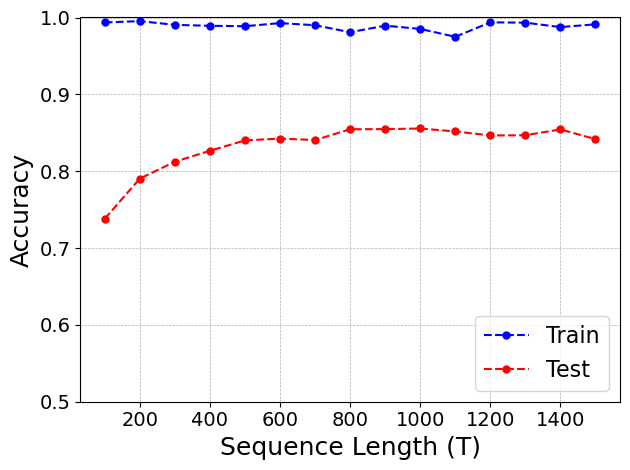

In [33]:
# Choose the index variable and the static variable for corresponding experiments
if experiment == 'length_independence':
    index_variable = T_values
    index_name = 'Sequence Length (T)'
    y_scale = 'linear'
    y_axis_label = 'Accuracy'
    static_variable = s_A_values[0]
    stat_var_name = 'sA'
else:
    raise ValueError("Experiment not found!")

# Choose a file name to save the results
plot_name = f"N_{N}_d_{d}_m_{m}_ep_{ep}_bs_{bs}_lr_{lr}_wd_{wd}_delta_{delta}_run_{run}"

# Plot the training and test accuracies on the same plot with color choice
plt.figure()
plt.plot(index_variable, list(train_results.values()), marker='.', linestyle='--', markersize=10, linewidth=1.5, color='blue', label='Train')
plt.plot(index_variable, list(test_results.values()), marker='.', linestyle='--', markersize=10, linewidth=1.5, color='red', label='Test')
# plt.plot(index_variable, np.abs(np.array(list(test_results.values())) - np.array(list(train_results.values()))), marker='.', linestyle='--', markersize=8, linewidth=1, color='green', label='Generalization Gap')
plt.xlabel(f'{index_name}', fontsize=18)
plt.ylabel(y_axis_label, fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title(f'{dataset.capitalize()} Dataset')
plt.yscale(y_scale)
plt.ylim(bottom = 0.5, top=1)
plt.margins(0.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=16)
plt.tight_layout()
# plt.savefig(f'results/{experiment}/{dataset}/train_test_{stat_var_name}_{static_variable}_{plot_name}.pdf')
# plt.savefig(f'results/{experiment}/{dataset}/train_test_{stat_var_name}_{static_variable}_{plot_name}.png', dpi=300)

In [34]:
if save_results:
    os.makedirs(f'results/{experiment}/{dataset}/significance', exist_ok=True)
    results_path = f'results/{experiment}/{dataset}/significance/sig_{stat_var_name}_{static_variable}_{plot_name}.csv'
    seq_len = sorted(train_results.keys())
    with open(results_path, mode='w', newline="") as f:
        writer = csv.writer(f)
        # Write the header
        writer.writerow(['T', 'Train Accuracy', 'Test Accuracy'])
        # Write the data
        for T in seq_len:
            train_acc = train_results[T]
            test_acc = test_results[T]
            writer.writerow([T, train_acc, test_acc])
